In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../src")

In [ ]:
import logging
logger = logging.getLogger()
logger.setLevel("DEBUG")

In [4]:
import torchChar
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

../src\torchChar\prepare_data.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
ckpt_path = torchChar.get_models_dir() / "alice_v6/checkpoints/epoch=2.ckpt"

In [6]:
model = torchChar.AliceModel.load_from_checkpoint(ckpt_path)

In [7]:
model

AliceModel(
  (conv1): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(50, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=25600, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=200, bias=True)
  (fc_radicals): Linear(in_features=500, out_features=215, bias=True)
  (fc_consonants): Linear(in_features=200, out_features=23, bias=True)
  (fc_vowels): Linear(in_features=200, out_features=40, bias=True)
  (fc_tones): Linear(in_features=200, out_features=6, bias=True)
)

In [8]:
model.register_output_hook("conv3")

In [9]:
model.eval()
for param in model.parameters():
    param.requires_grad=False

In [179]:
getattr(model, "co3nv3").out_channels

AttributeError: 'AliceModel' object has no attribute 'co3nv3'

In [167]:
X = torch.FloatTensor(1,64,64).random_(0,255)
X.requires_grad=True
optimizer = optim.Adam([X], lr=20)
filter_i = 50
loss_vec = []
act_vec = []
X_vec = []
X_grads = []
for _ in tqdm(range(20)):
    optimizer.zero_grad()
    pred = model(X)
    act = F.relu(model.layer_outputs['conv3'])
    mean_acts = act.mean(axis=[2,3])
    act_vec.append(mean_acts.squeeze().detach().numpy())
    X_vec.append(X.detach().clone())
    if X.grad is not None:
        X_grads.append(X.grad.detach().clone().numpy())
    loss = -mean_acts[0,filter_i]    
    loss.backward()
    optimizer.step()
    loss_vec.append(loss.item())

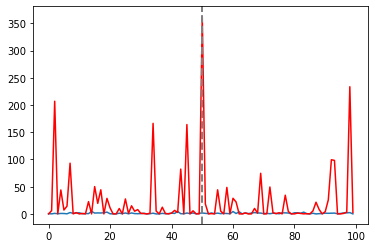

In [169]:
plt.plot(act_vec[0])
plt.plot(act_vec[-1], color='red')
plt.axvline(x=filter_i, color='gray', linestyle='--', linewidth=2)

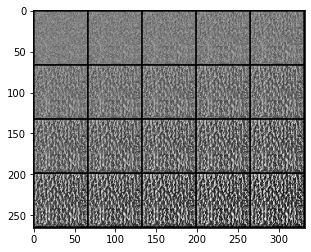

In [173]:
import numpy as np
Ximg = make_grid(X_vec[:10] + X_vec[-10:], nrow=5, normalize=True).detach().numpy()
plt.imshow(np.transpose(Ximg, (1,2,0)))

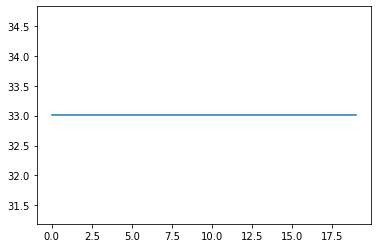

In [88]:
plt.plot([x[0,5,5] for x in X_vec])

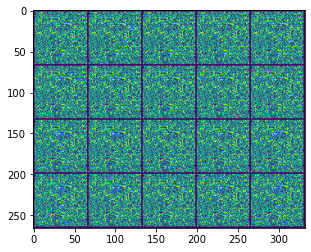

In [76]:
plt.imshow(Ximg[0])

In [79]:
import pickle
with (torchChar.get_data_dir() / "train_examples/char_examples_Yen.pkl").open("rb") as fin:
    yen = pickle.load(fin)

In [81]:
yen[0].bitmap

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,  52,  52,  52],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255]], dtype=uint8)